In [1]:
import pandas as pd
import numpy as np
import geopandas
from shapely.geometry import Point
import missingno as msn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# shapefile
country0 = geopandas.read_file("data/PAK_adm0.shp")

# load data
unrest = pd.read_csv('data/2010-01-01-2019-07-20-Pakistan.csv')

# clean data
unrest['event_date'] =  pd.to_datetime(unrest['event_date'], format='%d %B %Y')
unrest['coordinates'] = unrest[['longitude', 'latitude']].values.tolist()
unrest['coordinates'] = unrest['coordinates'].apply(Point)
unrest = geopandas.GeoDataFrame(unrest, geometry='coordinates')

In [3]:
unrest['Battles'] = unrest['event_type'] == 'Battles'
unrest['Explosions'] = unrest['event_type'] == 'Explosions/Remote violence'
unrest['Protests'] = unrest['event_type'] == 'Protests'
unrest['Riots'] = unrest['event_type'] == 'Riots'
unrest['Strategic developments'] = unrest['event_type'] == 'Strategic developments'
unrest['Violence against civilians'] = unrest['event_type'] == 'Violence against civilians'

daily_events = unrest.groupby('event_date')[['Battles','Explosions','Protests','Riots','Strategic developments','Violence against civilians']].sum()
daily_events = daily_events.reset_index()
daily_events['Total'] = daily_events['Battles'] + daily_events['Explosions'] + daily_events['Protests'] + daily_events['Riots'] + daily_events['Strategic developments'] + daily_events['Violence against civilians'] 
daily_events.head()
daily_events = daily_events[daily_events['event_date'].dt.year < 2019]

daily_events['month_year'] = daily_events.event_date.values.astype('datetime64[M]')

monthly_events = daily_events.groupby('month_year')[['Battles','Explosions','Protests','Riots','Strategic developments','Violence against civilians','Total']].sum()
monthly_events = monthly_events.reset_index()

monthly_events['Battles'] = monthly_events.iloc[:,1].rolling(window=5).mean()
monthly_events['Explosions'] = monthly_events.iloc[:,2].rolling(window=5).mean()
monthly_events['Protests'] = monthly_events.iloc[:,3].rolling(window=5).mean()
monthly_events['Riots'] = monthly_events.iloc[:,4].rolling(window=5).mean()
monthly_events['Strategic developments'] = monthly_events.iloc[:,5].rolling(window=5).mean()
monthly_events['Violence against civilians'] = monthly_events.iloc[:,6].rolling(window=5).mean()

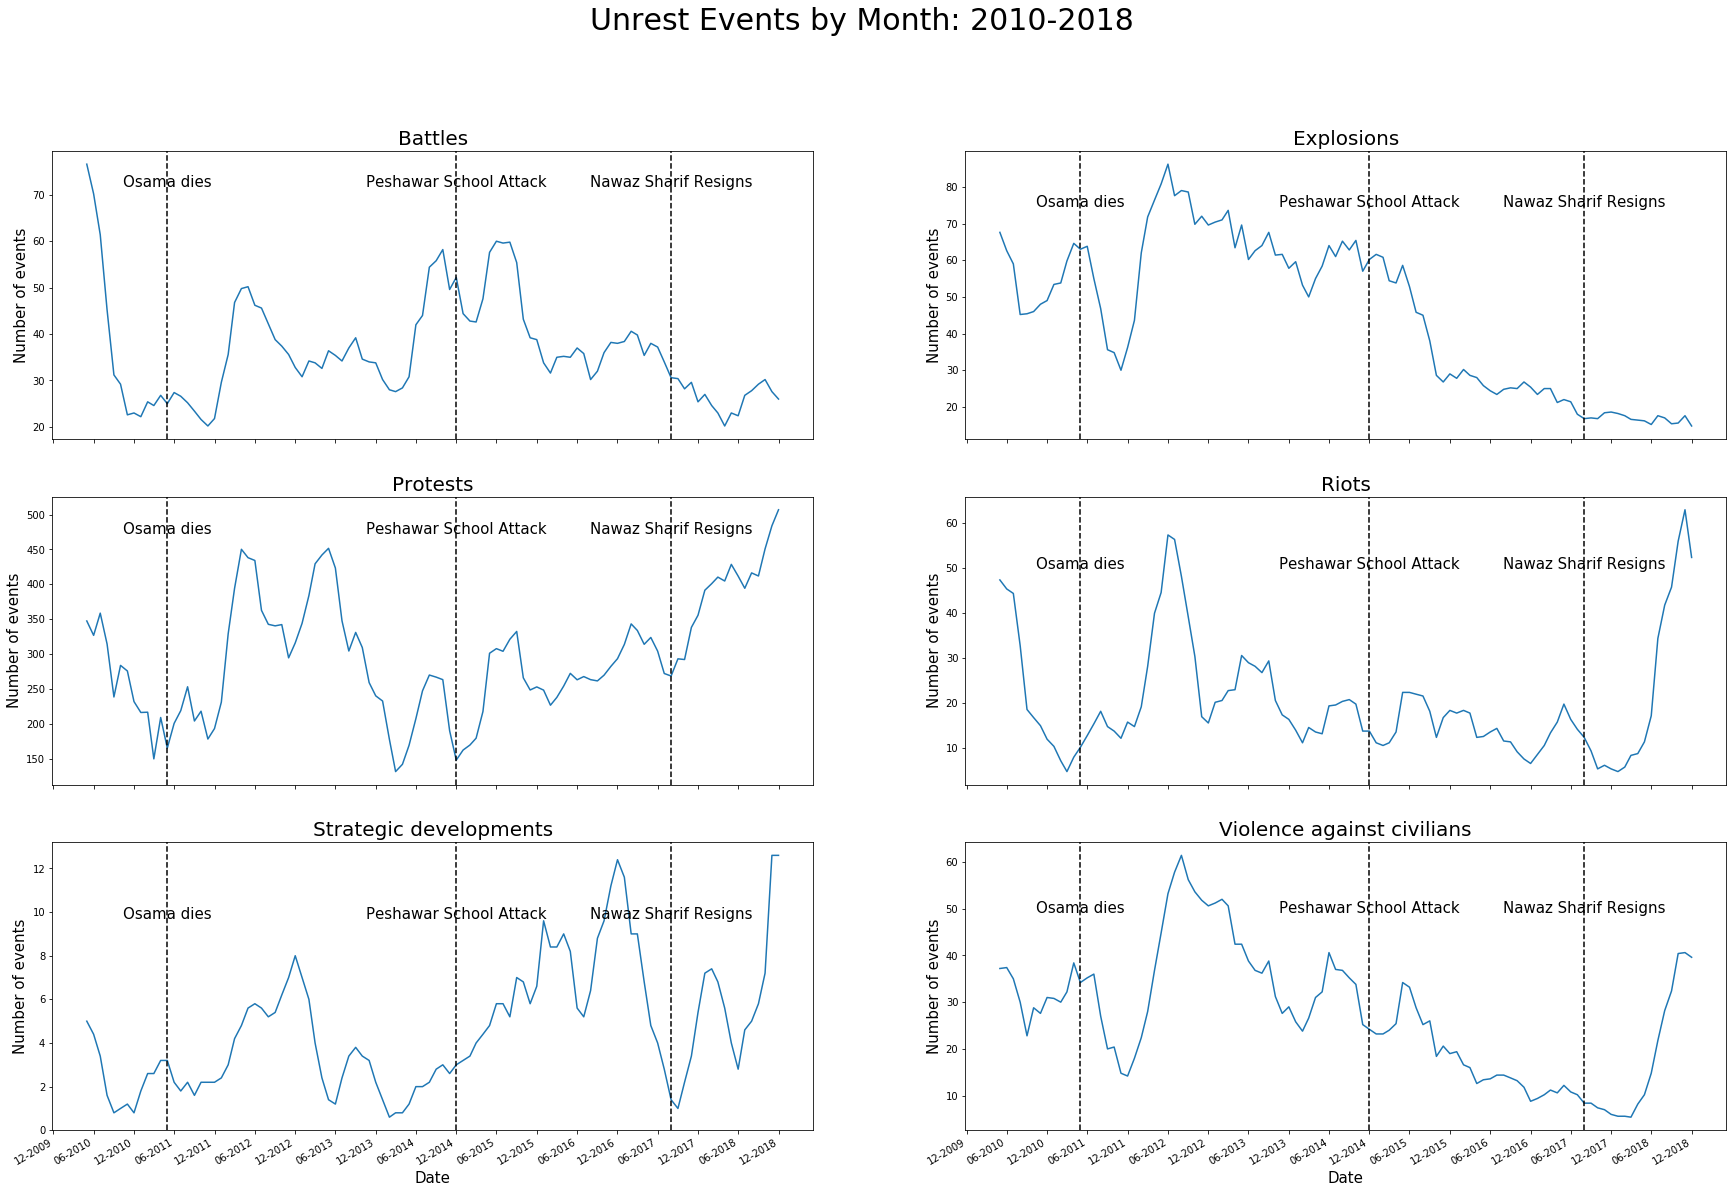

In [4]:
# Plot figure 2
fig, ax = plt.subplots(3, 2, sharex=True, figsize=(30,20))
fig.suptitle("Unrest Events by Month: 2010-2018", fontsize=30)

events = np.array([['Battles','Explosions'],['Protests','Riots'],['Strategic developments','Violence against civilians']])

for i in range(0,3):
    for j in range(0,2):
        
        ax[i][j].plot(monthly_events['month_year'],monthly_events[events[i,j]])
        ax[i][j].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        
        ax[i][j].axvline(x=pd.to_datetime('2011-05'), color='k', linestyle='--')
        ax[i][j].text(pd.to_datetime('2011-05'), (monthly_events[events[i,j]].min() + monthly_events[events[i,j]].max())*0.75,\
                      "Osama dies", ha='center', va='center',fontsize=15)
        
        ax[i][j].axvline(x=pd.to_datetime('2014-12'), color='k', linestyle='--')
        ax[i][j].text(pd.to_datetime('2014-12'), (monthly_events[events[i,j]].min() + monthly_events[events[i,j]].max())*0.75,\
                      "Peshawar School Attack", ha='center', va='center',fontsize=15)
        
        ax[i][j].axvline(x=pd.to_datetime('2017-08'), color='k', linestyle='--')
        ax[i][j].text(pd.to_datetime('2017-08'), (monthly_events[events[i,j]].min() + monthly_events[events[i,j]].max())*0.75,\
                      "Nawaz Sharif Resigns", ha='center', va='center',fontsize=15)
        
        ax[i][j].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gcf().autofmt_xdate()
        ax[i][j].set_xlabel('Date',fontsize=15)
        ax[i][j].set_ylabel('Number of events',fontsize=15)
        ax[i][j].set_title(events[i,j], fontsize=20)